In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil

%matplotlib inline

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # Remove when done with kernel
import importlib
importlib.reload(harmoutil)

<module 'harmoutil' from '../../../src/harmoutil.py'>

In [3]:
### Load raw data ###
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections

### Augment data ###
augmented_data = harmoutil.transpose_and_augment_data(raw_data)

data = [harmoutil.to_triads(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

chords = [ch for section in data for ch, mel in section]
# roots, suffixes = harmoutil.roots_and_suffixes(chords) # added for model 2
melodies_by_beats = [mel for section in data for ch, mel in section]

melodies_by_notes = []
for mel in melodies_by_beats:
    melodies_by_notes.append([n for b in mel for n in b])
notes = [n for sec in melodies_by_notes for n in sec]
print(len(chords), len(melodies_by_beats), len(melodies_by_notes), len(notes))

334344 334344 334344 2209944


In [4]:
### Define class integer mapping ###
notes_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
notes_index[-1] = len(notes_index)
notes_index['<end>'] = len(notes_index)
notes_index['<pad>'] = len(notes_index)

index_notes = dict(
    [(v, k) for k, v in notes_index.items()])


chords_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chords_index['<bos>'] = len(chords_index)
chords_index['<eos>'] = len(chords_index)

index_chords = dict(
    [(v, k) for k, v in chords_index.items()])

In [5]:
### Numerical variables ###
n_chords = len(chords_index)
n_notes = len(notes_index)
n_chord_notes = 12
max_melody_seq_len = max([len(mel) for mel in melodies_by_notes])
max_chords_seq_len = max([len(section) for section in data])
ch_context_window = 7


print("Total number of distinct chord labels:", n_chords)
print("Total number of distinct melody notes:", n_notes)
print("Number notes in chord:", n_chord_notes)
print("Maximum length of melody sequences:", max_melody_seq_len)
print("Maximum length of chord sequences:", max_chords_seq_len)
print("Number of chords taken into account for next prediction:", ch_context_window)

Total number of distinct chord labels: 63
Total number of distinct melody notes: 15
Number notes in chord: 12
Maximum length of melody sequences: 135
Maximum length of chord sequences: 58
Number of chords taken into account for next prediction: 7


In [6]:
### Build tensors ###

# Build data lists
input_melody_eos = []
input_chords_eos = []
target_chords_eos = []

for section in data:
    chord_sequence = [ch for ch, mel in section]
    padded_sequence = ['<bos>']*ch_context_window + chord_sequence + ['<eos>']
    for i in range(len(chord_sequence)+1):
        input_chords_eos.append(padded_sequence[i:i+ch_context_window])
        target_chords_eos.append(padded_sequence[i+ch_context_window])

    chord_mel = [mel for ch, mel in section]
    melody_sequence = []
    for mel in chord_mel:
        ch_mel = []
        for b in mel:
            for n in b:
                ch_mel.append(n)
        melody_sequence.append(ch_mel)
    melody_sequence += [['<end>']]
    input_melody_eos += melody_sequence

print(len(target_chords_eos), len(input_chords_eos))    
target_chords = [target_chords_eos[i] for i in range(len(target_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_chords = [input_chords_eos[i] for i in range(len(input_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_melody = [input_melody_eos[i] for i in range(len(input_melody_eos)) if not target_chords_eos[i] == '<eos>']    
print(len(target_chords), len(input_chords))


n_entries = len(target_chords)

X_melody = np.zeros((n_entries, max_melody_seq_len, n_notes), dtype='float32')
X_chords = np.zeros((n_entries, ch_context_window, n_chord_notes), dtype='float32')
Y = np.zeros((n_entries, n_chord_notes), dtype='float32')

# Y_C = np.zeros((n_entries, 1), dtype='float32')
# Y_Db = np.zeros((n_entries, 1), dtype='float32')
# Y_D = np.zeros((n_entries, 1), dtype='float32')
# Y_Eb = np.zeros((n_entries, 1), dtype='float32')
# Y_E = np.zeros((n_entries, 1), dtype='float32')
# Y_F = np.zeros((n_entries, 1), dtype='float32')
# Y_Gb = np.zeros((n_entries, 1), dtype='float32')
# Y_G = np.zeros((n_entries, 1), dtype='float32')
# Y_Ab = np.zeros((n_entries, 1), dtype='float32')
# Y_A = np.zeros((n_entries, 1), dtype='float32')
# Y_Bb = np.zeros((n_entries, 1), dtype='float32')
# Y_B = np.zeros((n_entries, 1), dtype='float32')



for i, (in_mel, in_ch, tg_ch) in enumerate(zip(input_melody, input_chords, target_chords)):
    
    # target chord
    if tg_ch == '<bos>':
        tg_chord_notes = [0]*12 # set <bos> to list of 0s
    else:
        tg_chord_notes = harmoutil.chord_to_notes(tg_ch)

    for j, pres in enumerate(tg_chord_notes):
        Y[i, j] = pres
        
        
    # input chords
    for j, ch in enumerate(in_ch):
        if ch == '<bos>':
            in_chord_notes = [0]*12 # set <bos> to list of 0s
        else:
            in_chord_notes = harmoutil.chord_to_notes(ch)
        for k, pres in enumerate(in_chord_notes):
            X_chords[i, j, k] = pres
            
    
    # input melody
    padded_melody = in_mel + ['<pad>']*(max_melody_seq_len - len(in_mel))
    for k, note in enumerate(padded_melody):
        X_melody[i, k, notes_index[note]] = 1
        
        
            
print(int(np.sum(X_melody)), n_entries*max_melody_seq_len)
# print(int(np.sum(X_chords)), n_entries*ch_context_window)
# print(int(np.sum(Y)), n_entries)


363228 363228
334344 334344
45115280 45136440


In [7]:
### Train/Validation/Test sets ###
seed = 1

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in strat_split.split(X_chords, Y):
    # train variables
    X_melody_train = X_melody[train_index]
    X_chords_train = X_chords[train_index]
    Y_train = Y[train_index]
    
    # auxiliary variables
    X_melody_aux = X_melody[aux_index]
    X_chords_aux = X_chords[aux_index]
    Y_aux = Y[aux_index]
    
    
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
for valid_index, test_index in strat_split.split(X_chords_aux, Y_aux):
    # validation variables
    X_melody_valid = X_melody_aux[valid_index]
    X_chords_valid = X_chords_aux[valid_index]
    Y_valid = Y_aux[valid_index]
    
    # test variables
    X_melody_test = X_melody_aux[test_index]
    X_chords_test = X_chords_aux[test_index]
    Y_test = Y_aux[test_index]    
    
    
print(X_melody_train.shape, X_chords_train.shape, Y_train.shape)
print(X_melody_valid.shape, X_chords_valid.shape, Y_valid.shape)
print(X_melody_test.shape, X_chords_test.shape, Y_test.shape)

# train_size = melody_train.shape[0]
# test_size = melody_test.shape[0]

(267475, 135, 15) (267475, 7, 12) (267475, 12)
(33434, 135, 15) (33434, 7, 12) (33434, 12)
(33435, 135, 15) (33435, 7, 12) (33435, 12)


In [8]:
### Define neural net architectur ###
latent_dim = 128

melody_input = Input(shape=(max_melody_seq_len, n_notes))
melody_gru = GRU(latent_dim)(melody_input)

chords_input = Input(shape=(ch_context_window, n_chord_notes))
chords_gru = GRU(latent_dim)(chords_input)

concat = concatenate([melody_gru, chords_gru])

# chord_dense = Dense(n_chords, activation='softmax')(concat)

chord_notes_dense = Dense(n_chord_notes, activation='sigmoid')(concat)

# C_o = Dense(1, activation='sigmoid')(concat)
# Db_o = Dense(1, activation='sigmoid')(concat)
# D_o = Dense(1, activation='sigmoid')(concat)
# Eb_o = Dense(1, activation='sigmoid')(concat)
# E_o = Dense(1, activation='sigmoid')(concat)
# F_o = Dense(1, activation='sigmoid')(concat)
# Gb_o = Dense(1, activation='sigmoid')(concat)
# G_o = Dense(1, activation='sigmoid')(concat)
# Ab_o = Dense(1, activation='sigmoid')(concat)
# A_o = Dense(1, activation='sigmoid')(concat)
# Bb_o = Dense(1, activation='sigmoid')(concat)
# B_o = Dense(1, activation='sigmoid')(concat)


model = Model([melody_input, chords_input], [chord_notes_dense])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 135, 15)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 12)         0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           55296       input_1[0][0]                    
____________________________________________________________________________________________________
gru_2 (GRU)                      (None, 128)           54144       input_2[0][0]                    
___________________________________________________________________________________________

In [9]:
### Introduce Early-Stopping and Save Best Performance callbacks ###
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
filepath = "../../models/model-4_aip_cc-7_triad.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# filepath = "../../models/model-4_cc-5.h5"
# mabpc = MultiAccuracyBestPerformanceCheckpoint(filepath, monitor=['val_dense_1_acc', 'val_dense_2_acc'], verbose=1)


In [11]:
### Train model ###
batch_size = 32
epochs = 50

history = model.fit([X_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size, callbacks=[bp])
# history = model.fit([X_melody_train, X_chords_train],
#                     [Y_C_train, Y_Db_train, Y_D_train, Y_Eb_train, Y_E_train, Y_F_train, Y_Gb_train, Y_G_train, Y_Ab_train, Y_A_train, Y_Bb_train, Y_B_train],
#                     epochs=epochs, 
#                     validation_data=([X_melody_valid, X_chords_valid],
#                                      [Y_C_valid, Y_Db_valid, Y_D_valid, Y_Eb_valid, Y_E_valid, Y_F_valid, Y_Gb_valid, Y_G_valid, Y_Ab_valid, Y_A_valid, Y_Bb_valid, Y_B_valid]), 
#                     batch_size=batch_size)


Train on 267475 samples, validate on 33434 samples
Epoch 1/50
267475/267475 [==============================] - 1114s - loss: 0.4452 - acc: 0.8030 - val_loss: 0.4129 - val_acc: 0.8212
Epoch 2/50
267475/267475 [==============================] - 1104s - loss: 0.3892 - acc: 0.8318 - val_loss: 0.3674 - val_acc: 0.8424
Epoch 3/50
267475/267475 [==============================] - 1100s - loss: 0.3507 - acc: 0.8505 - val_loss: 0.3441 - val_acc: 0.8544
Epoch 4/50
267475/267475 [==============================] - 1100s - loss: 0.3306 - acc: 0.8609 - val_loss: 0.3325 - val_acc: 0.8605
Epoch 5/50
267475/267475 [==============================] - 1098s - loss: 0.3168 - acc: 0.8677 - val_loss: 0.3238 - val_acc: 0.8648
Epoch 6/50
267475/267475 [==============================] - 1100s - loss: 0.3064 - acc: 0.8725 - val_loss: 0.3187 - val_acc: 0.8680
Epoch 7/50
267475/267475 [==============================] - 1099s - loss: 0.2983 - acc: 0.8764 - val_loss: 0.3138 - val_acc: 0.8704
Epoch 8/50
267475/267475 

267475/267475 [==============================] - 1099s - loss: 0.2629 - acc: 0.8922 - val_loss: 0.2965 - val_acc: 0.8793
Epoch 29/50
267475/267475 [==============================] - 1101s - loss: 0.2613 - acc: 0.8927 - val_loss: 0.2973 - val_acc: 0.8797
Epoch 30/50
267475/267475 [==============================] - 1097s - loss: 0.2606 - acc: 0.8930 - val_loss: 0.2962 - val_acc: 0.8799
Epoch 31/50
267475/267475 [==============================] - 1093s - loss: 0.2617 - acc: 0.8923 - val_loss: 0.2933 - val_acc: 0.8808
Epoch 32/50
267475/267475 [==============================] - 1094s - loss: 0.2606 - acc: 0.8930 - val_loss: 0.2954 - val_acc: 0.8798
Epoch 33/50
267475/267475 [==============================] - 1094s - loss: 0.2612 - acc: 0.8925 - val_loss: 0.2969 - val_acc: 0.8795
Epoch 34/50
267475/267475 [==============================] - 1093s - loss: 0.2605 - acc: 0.8929 - val_loss: 0.2956 - val_acc: 0.8800
Epoch 35/50
267475/267475 [==============================] - 1095s - loss: 0.2630

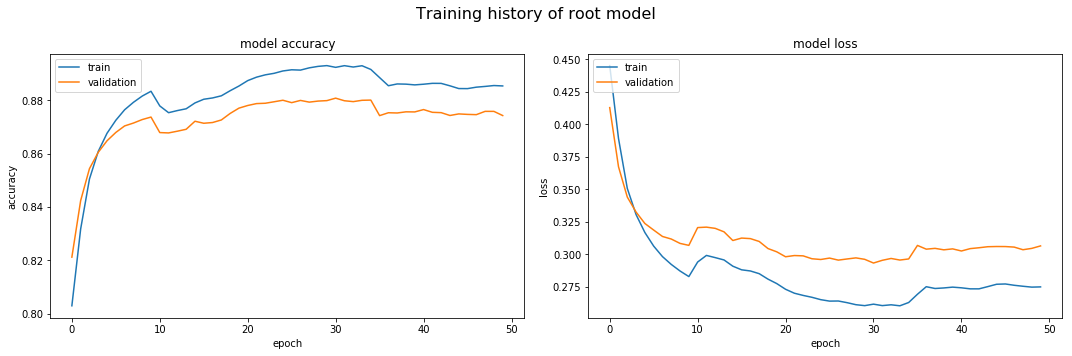

In [12]:
### Visualize model learning ###
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [13]:
### Load best performance model ###
model = load_model("../../models/model-4_aip_cc-7_triad.h5")

In [14]:
### Evaluate predictions ###
# [C_pred, Db_pred, D_pred, Eb_pred, E_pred, F_pred, Gb_pred, G_pred, Ab_pred, A_pred, Bb_pred, B_pred] = model.predict([X_melody_test, X_chords_test])
chord_pred = model.predict([X_melody_test, X_chords_test])

# Build tensor of combined predictions
# chord_pred = np.zeros((len(test_index), n_chords), dtype='float32')
# for i, (root_softmax, suffix_softmax) in enumerate(zip(root_pred, suffix_pred)):
#     root_index = np.argmax(root_softmax)
#     suffix_index = np.argmax(suffix_softmax)
#     root_str = index_roots[root_index]
#     suffix_str = index_suffixes[suffix_index]
#     label = root_str + suffix_str if not root_str == 'NC' else 'NC' 
#     chord_pred[i, chords_index[label]] = 1
    

# Compute accuracy and kappa score 
# print("Categorical accuracy of root prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_roots_test, harmoutil.softmax_to_argmax(root_pred))))
# print("Categorical accuracy of suffix prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_suffixes_test, harmoutil.softmax_to_argmax(suffix_pred))))
print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_test, chord_pred)))

# print("Kappa score of root prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_roots_test, harmoutil.softmax_to_argmax(root_pred))))
# print("Kappa score of suffix prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_suffixes_test, harmoutil.softmax_to_argmax(suffix_pred))))
print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_test, chord_pred)))

Categorical accuracy of combined chord prediction: 0.8803
TP: 68416 TN: 284791 FP: 16334 FN: 31679
316470 301125
84750 100095
Kappa score of combined chord prediction: 0.6632


In [15]:
# print(chord_pred[:20])
# print(Y_test[:20])
# for i in chord_pred[:20]:
#     print([int(round(j)) for j in i])
    
for i in range(30):
    print("---")
    for k in X_chords_test[i]:
        print(k)
    print("sample:", i)
#     print(X_chords_test[i])
    print(Y_test[i])
    print([int(round(j)) for j in chord_pred[i]])

---
[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
[1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
[0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
sample: 0
[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
---
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
sample: 1
[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
---
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
sample: 2
[0. 1. 0. 

In [16]:
counts = []
for row in chord_pred:
    result = []
    count = 0
    for note in row:
        result.append(round(note))
        count += note
    counts.append(count)
#     print(result)
print("Avg notes per prediction:", sum(counts)/len(counts))

Avg notes per prediction: 2.9967046239749693


In [17]:
print("F-score: {0:.4f}".format(harmoutil.compute_binary_fscore(Y_test, chord_pred)))

F-score: 0.7403


In [18]:
### Check inter-chord performance ###

miss_pred_pitches = []
miss_test_pitches = []
count = 0

for pred_pitches, test_pitches in zip(chord_pred, Y_test):
    round_pred_pitches = [int(round(pitch)) for pitch in pred_pitches]
    round_test_pitches = [int(pitch) for pitch in test_pitches]
    
    if not round_pred_pitches == round_test_pitches:
        miss_pred_pitches.append(round_pred_pitches)
        miss_test_pitches.append(round_test_pitches)
        count+=1
    
print(count)

def chord_grader(pred, test):
    score = 0
    for pr_pitch, te_pitch in zip(pred, test):
        score += int((pr_pitch == te_pitch) and pr_pitch == 1)
    return score

scores = []
for pred_pitches, test_pitches in zip(miss_pred_pitches, miss_test_pitches):
#     print(pred_pitches, test_pitches)
    scores.append(chord_grader(pred_pitches, test_pitches))
    
print("Avg score:", sum(scores)/len(scores))
print("Std:", ((1/len(scores))*sum([(i-sum(scores)/len(scores))**2 for i in scores]))**(1/2))

18781
Avg score: 1.3044566317022523
Std: 0.9330132133849536


In [19]:
print(len(Y_test))

33435


In [20]:
### pick random start from the test data ###
seq_seed = 42

random.seed(seq_seed)
random_index = random.randint(0, X_chords_test.shape[0]-1)
X_initial_seq = X_chords_test[random_index]
print(X_initial_seq)

[[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]]


In [21]:
### Afternoon in Paris ###

# build script that uses prediction function

aip_melody = [[2, 0, 11, 0, 2, 4], [3, 7, 10, 2], [0, 2, 5], [0, 10, 9, 10, 0, 2], [1, 5, 8, 0], [10, 0, 3], [10, 8, 3, 7, 10, 8, 5], [-1], [7, 5, 7], [4, 7, 11, 2], [0, 2, 4, 7], [5, 9, 0, 4, 2], [4, 7]]
alt_aip_melody = [[6, 0, 5, 8, 3, 4], [3, 7, 10, 2], [0, 2, 5], [0, 10, 9, 10, 0, 2], [1, 5, 8, 0], [10, 0, 3], [10, 8, 3, 7, 10, 8, 5], [-1], [7, 5, 7], [4, 7, 11, 2], [0, 2, 4, 7], [5, 9, 0, 4, 2], [4, 7]]

aip_chords = ['Cj7', 'C-7', 'F7', 'Bbj7', 'Bb-7', 'Eb7', 'Abj7', 'D-7', 'G7', 'Cj7', 'A-7', 'D-7', 'G7']

    
def build_mel_tensor(mel):
    padded_mel = mel + ['<pad>']*(max_melody_seq_len - len(mel))
    X_mel = np.zeros((1, max_melody_seq_len, n_notes), dtype='float32')
    for k, note in enumerate(padded_mel):
        X_mel[0, k, notes_index[note]] = 1
    return X_mel
    

def build_ch_tensor(in_ch):
    X_ch = np.zeros((1, ch_context_window, n_chord_notes), dtype='float32')
    for j, ch in enumerate(in_ch): # iterate over past chords
        for k, pres in enumerate(ch): # iterate over pitches of past chord
            X_ch[0, j, k] = pres
    return X_ch

harmony = []
past_chords = [[0]*n_chord_notes]*(ch_context_window)


for mel_notes in aip_melody:
#     print("Past chords:")
#     for chch in past_chords:
#         print(chch)
    input_ch = build_ch_tensor(past_chords)                  # build past chords tensor
#     print("Input chords tensor:")
#     print(input_ch)
    input_mel = build_mel_tensor(mel_notes)                  # build tensor for current melody
    next_pred = model.predict([input_mel, input_ch])         # predict target chord from current melody and past chords
#     print(next_pred)
    next_chord = [int(round(n)) for n in next_pred[0]]       # convert prediction to chord label 
#     print("Next:", next_chord)
#     print("---")
    past_chords = past_chords[1:]+[next_chord]               # update past chord sequence with newly predicted chord
    harmony.append(next_chord)                               # append new chord label to harmony list
    
print("Harmony")
for ham in harmony:
    print(ham)


Harmony
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]


In [22]:
aip_chords = ['Cj7', 'C-7', 'F7', 'Bbj7', 'Bb-7', 'Eb7', 'Abj7', 'D-7', 'G7', 'Cj7', 'A-7', 'D-7', 'G7']
for ham in aip_chords:
    print(ham, harmoutil.chord_to_notes(ham))

Cj7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
C-7 [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
F7 [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Bbj7 [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]
Bb-7 [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Eb7 [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Abj7 [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
D-7 [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
G7 [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Cj7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
A-7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
D-7 [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
G7 [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
